In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from urllib.parse import quote_plus
from sqlalchemy import create_engine
import json

db_config = open('../../config/database.json')
db_config = json.load(db_config)

# PostgreSQL database connection URL (update with your actual database URL)

# Create a SQLAlchemy engine to connect to the database
engine = create_engine("postgresql://postgres:%s@localhost:5432/finance" % quote_plus(db_config["pg_password"]))

# SQL query to fetch data from the database (replace with your query)
sql_query = "SELECT * FROM us_data"

# Execute the query and load the results into a pandas DataFrame
raw_data = pd.read_sql_query(sql_query, engine)

# Close the database connection when done
engine.dispose()

# Print the first few rows of the DataFrame
print(raw_data.shape)
raw_data.dtypes

(239830, 11)


complaint_id                    float64
date_received                    object
date_sent_to_company             object
product                          object
consumer_complaint_narrative     object
submittedvia                     object
timelyresponse                   object
issue                            object
subissue                         object
company                          object
state                            object
dtype: object

In [53]:
import json
ml_pipeline_config = open('../../config/ml_pipeline.json')
ml_pipeline_config = json.load(ml_pipeline_config)

In [54]:
raw_data.head()

,complaint_id,date_received,date_sent_to_company,product,consumer_complaint_narrative,submittedvia,timelyresponse,issue,subissue,company,state
0,7188019.0,06/30/23,06/30/23,Credit card or prepaid card,I signed up for a Citi Bank card and and have ...,Web,Yes,Struggling to pay your bill,Credit card company won't work with you while ...,"CITIBANK, N.A.",NC
1,7188842.0,06/30/23,06/30/23,Debt collection,On XX/XX/2023 at XXXXXXXX XXXX I received a bi...,Web,Yes,False statements or representation,Attempted to collect wrong amount,Global Lending Services LLC,CO
2,7189350.0,06/30/23,06/30/23,Debt collection,"Good morning -- I bought the equipment, but th...",Web,Yes,Attempts to collect debt not owed,Debt is not yours,TRANSWORLD SYSTEMS INC,TX
3,7191472.0,07-01-2023,07-01-2023,"Credit reporting, credit repair services, or o...",NOTICE TO SUPPRESS LISTED ACCOUNTS The FCRA st...,Web,Yes,Incorrect information on your report,Account information incorrect,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",TX
4,7106838.0,06-12-2023,06-12-2023,Credit card or prepaid card,I urge you to expedite the update of my accoun...,Web,Yes,Problem with a credit reporting company's inve...,Was not notified of investigation status or re...,Experian Information Solutions Inc.,NC


In [55]:
raw_data.shape

(239830, 11)

In [56]:
raw_data.isnull().sum()

complaint_id                        3
date_received                       0
date_sent_to_company                0
product                             0
consumer_complaint_narrative        0
submittedvia                        0
timelyresponse                      3
issue                               0
subissue                        10988
company                             0
state                             571
dtype: int64

In [57]:
raw_data.groupby('product').consumer_complaint_narrative.count()

product
Checking or savings account                                                      13213
Credit card                                                                       6385
Credit card or prepaid card                                                      11567
Credit reporting or other personal consumer reports                              56424
Credit reporting, credit repair services, or other personal consumer reports    117221
Debt collection                                                                  16605
Debt or credit management                                                          139
Money transfer, virtual currency, or money service                                3892
Mortgage                                                                          5787
Payday loan, title loan, or personal loan                                         1450
Payday loan, title loan, personal loan, or advance loan                            659
Prepaid card                       

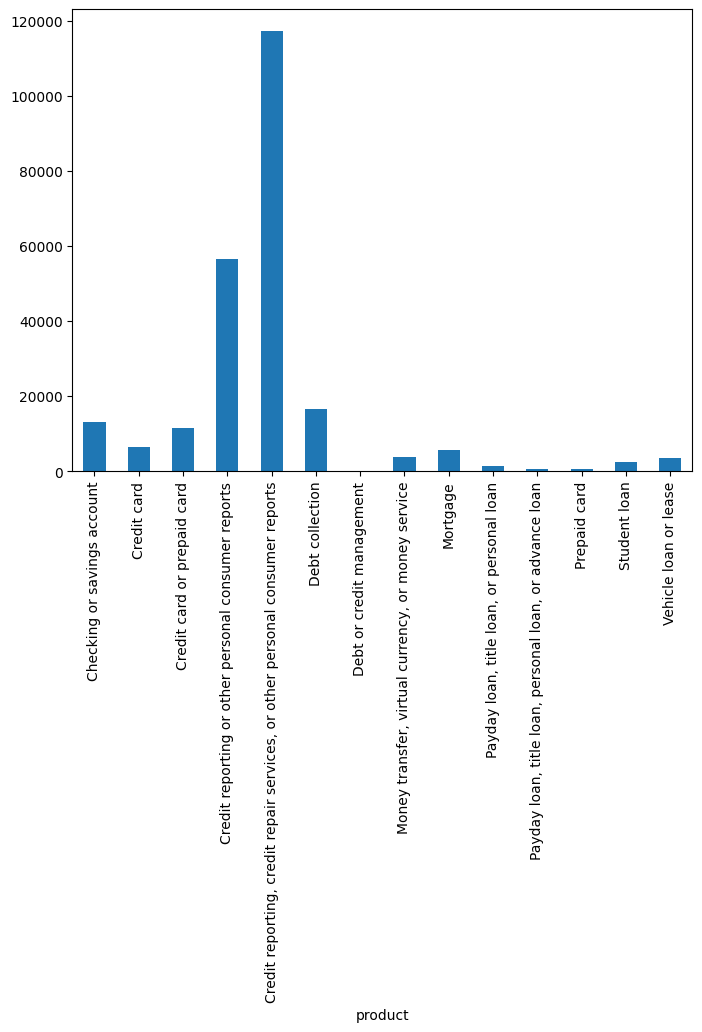

In [58]:
fig = plt.figure(figsize=(8,6))
raw_data.groupby('product').consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [41]:
# data = raw_data[['product','consumer_complaint_narrative']]
raw_data = raw_data.replace('',None)
# data = data[data['consumer_complaint_narrative'].notnull()]
raw_data.to_csv(ml_pipeline_config["processed_data_path"],index=False)

In [40]:
ml_pipeline_config["processed_data_path"]

'../../data/processed_data.csv'

In [47]:
raw_data['product'].value_counts()

product
Credit reporting or other personal consumer reports        15263
Debt collection                                              988
Credit card                                                  876
Checking or savings account                                  687
Mortgage                                                     333
Money transfer, virtual currency, or money service           212
Student loan                                                 190
Vehicle loan or lease                                        177
Payday loan, title loan, personal loan, or advance loan      107
Prepaid card                                                  56
Debt or credit management                                     30
Name: count, dtype: int64